In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fim import apriori as fim_apriori
from gsp import apriori as gsp_apriori

# Task 4: Frequent Pattern mining and Association Rule Mining

In [2]:
df_geo = pd.read_csv('../geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('../ram.csv', sep=',', index_col=0)

# Processed dataset split for VCS purposes
df_sales_part1 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('../time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('../vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#Merge data into a single dataframe
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

#Make the ram_code feature a string in order to use it with gsp
df_sales_merged.loc[:, "ram_code"] = df_sales_merged.loc[:, "ram_code"].astype(int).apply(str)

In [4]:
df_sales_merged.head()

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
2602347,3719,1,ADATA,Adata,0.5,DDR,400,20130322,2013,3,...,12,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.749032,10.65
2602348,3719,1,ADATA,Adata,0.5,DDR,400,20130323,2013,3,...,12,18,Europe,Germany,berlin,EUR,32,geizhals_unknown,13.828708,10.65
2602349,3719,1,ADATA,Adata,0.5,DDR,400,20130326,2013,3,...,13,28,Europe,Germany,saxony,EUR,32,geizhals_unknown,13.694297,10.65
2602350,3719,1,ADATA,Adata,0.5,DDR,400,20130327,2013,3,...,13,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.690530,10.65
2602351,3719,1,ADATA,Adata,0.5,DDR,400,20130328,2013,3,...,13,27,Europe,Germany,saarland,EUR,32,geizhals_unknown,13.605216,10.65


## Dataframe pre-processing  
Here we are interested in making the sales dataframe more suitable for our analyses.

### Feature removal

In [5]:
feat_to_drop = ["Id", "geo_code", "vendor_code", "sales_currency", "year", "month", "day", "week"]

df_sales_proc = df_sales_merged.drop(feat_to_drop, axis=1)
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
2602347,1,ADATA,Adata,0.5,DDR,400,20130322,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.749032
2602348,1,ADATA,Adata,0.5,DDR,400,20130323,Europe,Germany,berlin,EUR,geizhals_unknown,13.828708
2602349,1,ADATA,Adata,0.5,DDR,400,20130326,Europe,Germany,saxony,EUR,geizhals_unknown,13.694297
2602350,1,ADATA,Adata,0.5,DDR,400,20130327,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.690530
2602351,1,ADATA,Adata,0.5,DDR,400,20130328,Europe,Germany,saarland,EUR,geizhals_unknown,13.605216


Removed some features that are either redundant or do not carry useful information for this task.

### time_code type adjustment

In [6]:
df_sales_proc["time_code"] = pd.to_datetime(df_sales_proc["time_code"], format="%Y%m%d")
df_sales_proc["time_code"]

2602347   2013-03-22
2602348   2013-03-23
2602349   2013-03-26
2602350   2013-03-27
2602351   2013-03-28
             ...    
6014673   2017-03-10
6014674   2017-05-05
6014675   2017-05-10
6014676   2017-05-11
6014677   2017-06-08
Name: time_code, Length: 3342700, dtype: datetime64[ns]

We will use the timecodes to group the frequent sequences by smaller units of time compared to the ones available therefore we need to convert them to the datatime pandas type.

### Feature discretisation
We are interested in discretising memory, clock and the sales value.

#### Memory

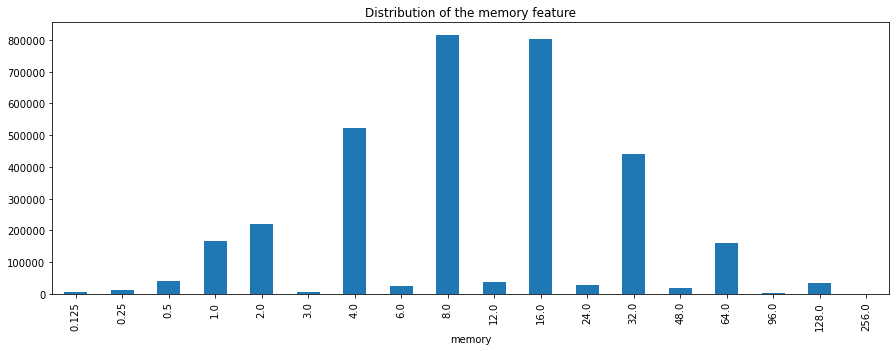

In [7]:
plt.figure(figsize=(15,5))
plt.title("Distribution of the memory feature")
df_sales_proc.groupby("memory").size().plot(kind="bar")
plt.show()

The distribution of memory has an almost symmetric distribution, we can use this to define different bins.  
We will use the following ranges: [0,4], [6,8], [12,16], [24,32] and [48,256].  

This choice is in part due to the distribution above and in part based on our knowledge of sizes of ram found in the commercial products.  
In low cost/power/old products usually the amount of ram doesn't exceed 4 GB, mid-range can go up to 8 GB and so on.  
Regarding the last range it reflects the fact that amount of memory is usually used for servers/high-end workstations, therefore they belong to a class of their own.

In [8]:
bins = pd.IntervalIndex.from_tuples([(0, 4), (6, 8), (12, 16), (24, 32), (48, 256)], closed="both")

df_sales_proc.loc[:, "memory"] = pd.cut(df_sales_proc['memory'].astype(int), bins, right=False)
df_sales_proc.loc[:, "memory"] = df_sales_proc["memory"].astype(str) + '_mem'

#### Clock

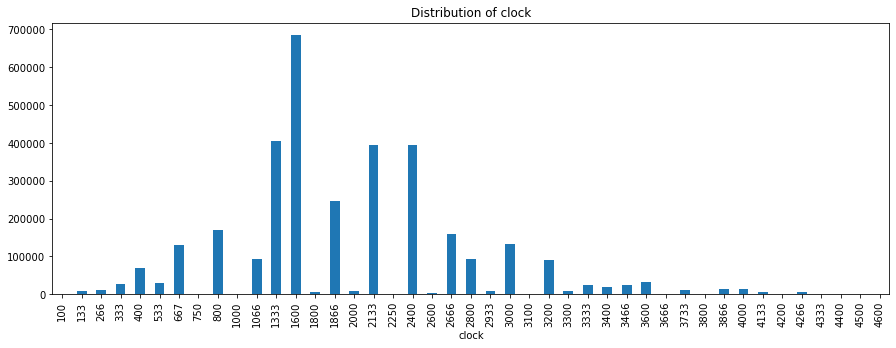

In [9]:
plt.figure(figsize=(15,5))
plt.title("Distribution of clock")
df_sales_proc.groupby(["clock"]).size().plot(kind="bar")
plt.show()

In [10]:
bins = pd.IntervalIndex.from_tuples([(100, 1333), (1600, 1800), (1866, 2250), (2400, 3200), (3300, 4600)], closed="both")

df_sales_proc.loc[:, "clock"] = pd.cut(df_sales_proc['clock'].astype(int), bins, right=False)
df_sales_proc.loc[:, "clock"] = df_sales_proc["clock"].astype(str) + '_clock'

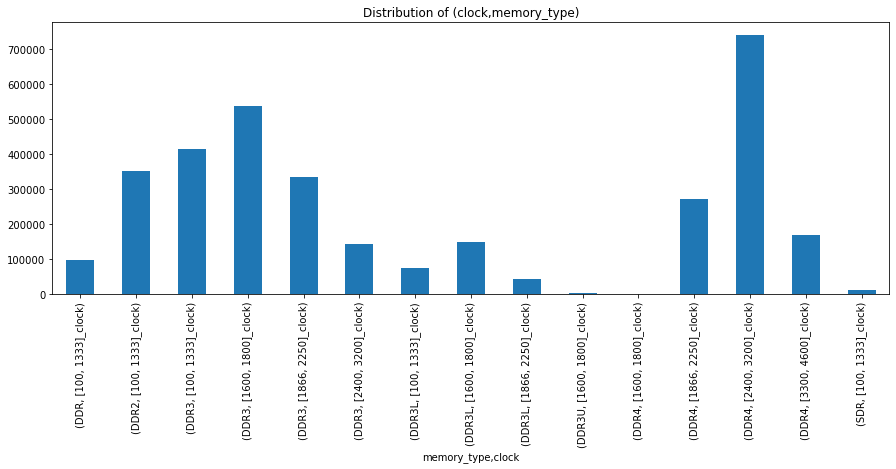

In [11]:
plt.figure(figsize=(15,5))
plt.title("Distribution of (clock,memory_type)")
df_sales_proc.groupby(["memory_type", "clock"]).size().plot(kind="bar")
plt.show()

Again we defined interval roughly based on a equal-frequency binning approach and what can be considered a low-end/high-end product. 

Note that this is only a rough approximation, for the purpouse of discretising we are ignoring the memory_type even though the distribution of the clock is not uniform across the DDR types.

#### Sales

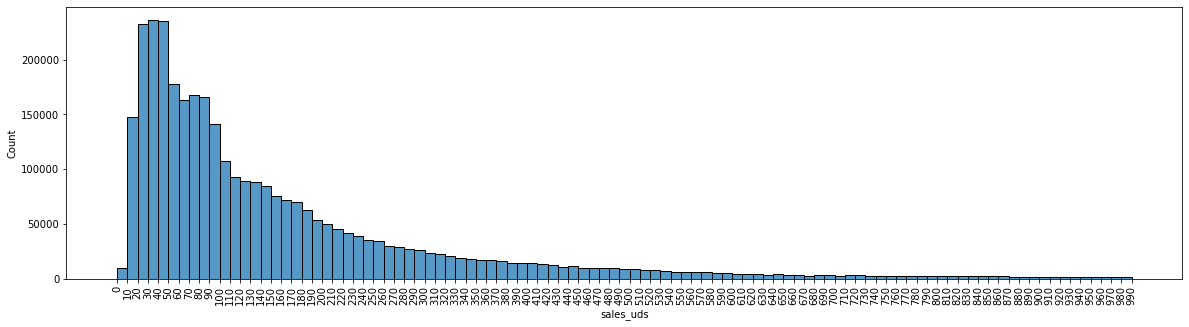

In [12]:
bins = range(0, 1000, 10)

plt.figure(figsize=(20,5))
sn.histplot(df_sales_proc["sales_uds"], bins=bins)
plt.xticks(bins, rotation=90)
plt.show()

In this case we will split the data based on the frequency of the entries using quantiles, definining 10 ranges.

In [13]:
pd.qcut(df_sales_proc["sales_uds"].astype(int), 10).unique()

[(0.999, 27.0], (27.0, 41.0], (41.0, 57.0], (57.0, 78.0], (78.0, 99.0], (99.0, 134.0], (134.0, 177.0], (177.0, 246.0], (246.0, 395.0], (395.0, 10630.0]]
Categories (10, interval[float64]): [(0.999, 27.0] < (27.0, 41.0] < (41.0, 57.0] < (57.0, 78.0] ... (134.0, 177.0] < (177.0, 246.0] < (246.0, 395.0] < (395.0, 10630.0]]

In [14]:
df_sales_proc.loc[:, "sales_uds"] = pd.qcut(df_sales_proc["sales_uds"].astype(int), 10)

df_sales_proc.loc[:, "sales_uds"] = df_sales_proc["sales_uds"].astype(str) + '_sales_uds'

#### Results

In [15]:
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
2602347,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-22,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602348,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-23,Europe,Germany,berlin,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602349,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-26,Europe,Germany,saxony,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602350,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-27,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602351,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-28,Europe,Germany,saarland,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"


## Association rules

### Vendor-level associations
Due to memory constraints we are forced to apply a stratified (with respect to the vendor) random sampling to the sales dataset.

In [16]:
df_assoc_sampled = df_sales_proc.groupby(["name_vendor"]).sample(frac=0.001, random_state=0)
num_trans_assoc = df_assoc_sampled.shape[0]

print(f"Number of transactions sampled: {num_trans_assoc}")
df_assoc_sampled.head()

Number of transactions sampled: 3341


,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
3528941,854,CRUCIAL,Crucial,"[0, 4]_mem",DDR4,"[1866, 2250]_clock",2017-10-22,Oceania,New Zeland,south island-southern,NZD,1stWave Technologies,"(41.0, 57.0]_sales_uds"
5089507,2201,KINGSTON,Kingston Hyperx Fury,"[6, 8]_mem",DDR4,"[2400, 3200]_clock",2017-08-05,Europe,Germany,mecklenburg-vorpommern,EUR,ARLT,"(99.0, 134.0]_sales_uds"
3538678,857,CRUCIAL,Crucial,"[6, 8]_mem",DDR4,"[1866, 2250]_clock",2017-10-04,America,United States of America,north-east usa,USD,Adorama,"(99.0, 134.0]_sales_uds"
3452453,804,CRUCIAL,Crucial,"[6, 8]_mem",DDR3,"[1600, 1800]_clock",2017-02-04,America,United States of America,north-east usa,USD,Adorama,"(78.0, 99.0]_sales_uds"
3556244,861,CRUCIAL,Crucial,"[12, 16]_mem",DDR4,"[2400, 3200]_clock",2017-10-10,America,United States of America,mid-atalntic,USD,Adorama,"(134.0, 177.0]_sales_uds"


In [17]:
trans_ram_code = df_assoc_sampled.groupby(["name_vendor"])["ram_code"].apply(list)
trans_ram_code.head()

name_vendor
1stWave Technologies                                                [854]
ARLT                                                               [2201]
Adorama                                                   [857, 804, 861]
Alternate                                               [1297, 1485, 440]
Alza                    [679, 973, 2189, 3234, 2188, 2046, 857, 1601, ...
Name: ram_code, dtype: object

We defined the transactions with respect to the vendor in order to find association rules that hold for multiple vendors.  

In [18]:
baskets_ram = trans_ram_code.values
num_bask_ram = baskets_ram.shape[0]
num_bask_ram

65

In [19]:
rules_ram = fim_apriori(baskets_ram, supp=5, zmin=2, target='r', conf=60, report='ascl')
print('Number of rules:', len(rules_ram))

Number of rules: 5563


In [20]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

rules_ram_df = pd.DataFrame(rules_ram, columns=report_cols)
rules_ram_df["Prem. len"] = rules_ram_df["Prem."].apply(lambda x: len(x))

In [21]:
rules_ram_df.sort_values(["Support (abs)", "Lift"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. len
3373,1404,"(1591,)",5,0.076923,0.833333,7.738095,1
3374,1591,"(1404,)",5,0.076923,0.714286,7.738095,1
5553,1404,"(955,)",5,0.076923,0.833333,7.738095,1
5554,955,"(1404,)",5,0.076923,0.714286,7.738095,1
5561,1404,"(698,)",5,0.076923,0.833333,7.738095,1
...,...,...,...,...,...,...,...
25,2186,"(2055,)",3,0.046154,0.600000,3.900000,1
50,2186,"(2315,)",3,0.046154,0.600000,3.900000,1
67,2186,"(2037,)",3,0.046154,0.600000,3.900000,1
110,2186,"(858,)",3,0.046154,0.600000,3.900000,1


The support for these rules is very low, no rule goes above 7% support.

In [22]:
rules_ram_df.sort_values(["Lift", "Prem. len", "Support (abs)"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. len
181,3558,"(1432, 2296, 955, 2299, 698, 1404)",3,0.046154,0.75,16.25,6
1364,2245,"(1432, 2296, 955, 2299, 698, 1404)",3,0.046154,0.75,16.25,6
1456,1156,"(1432, 2296, 955, 2299, 698, 1404)",3,0.046154,0.75,16.25,6
2560,1365,"(1432, 2296, 955, 2299, 698, 1404)",3,0.046154,0.75,16.25,6
2635,1195,"(1432, 2296, 955, 2299, 698, 1404)",3,0.046154,0.75,16.25,6
...,...,...,...,...,...,...,...
25,2186,"(2055,)",3,0.046154,0.60,3.90,1
50,2186,"(2315,)",3,0.046154,0.60,3.90,1
67,2186,"(2037,)",3,0.046154,0.60,3.90,1
110,2186,"(858,)",3,0.046154,0.60,3.90,1


There are plenty of entries with multiple premises.

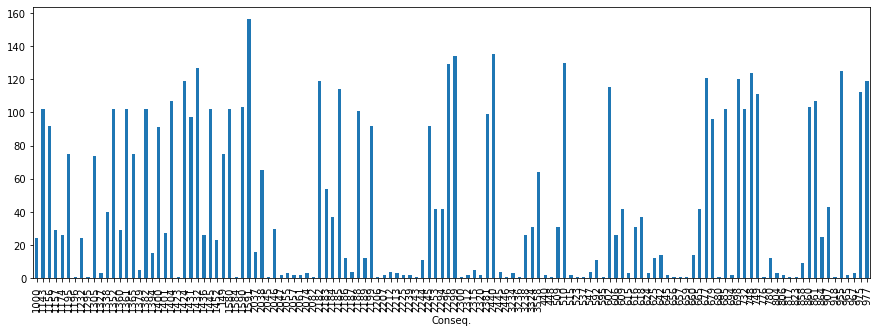

In [23]:
plt.figure(figsize=(15,5))
rules_ram_df.groupby("Conseq.").size().plot(kind="bar")
plt.show()

#### Features
In order to facilitate the analysis we will extract some features from both the premises and consequent.

In [24]:
def add_features_num(df):
    
    new_df = pd.DataFrame(index=df.index)
    
    for idx, row in df.iterrows():
        
        conseq_entry = df_ram.loc[int(row["Conseq."])]
        
        prem_list = [int(x) for x in row["Prem."]]
        prem_df = df_ram.loc[prem_list]
        
        new_df.loc[idx, "Conseq."] = row["Conseq."]
        new_df.loc[idx, "Num Prem."] = len(prem_list)
        
        new_df.loc[idx, "C. mem"] = int(conseq_entry["memory"])
        new_df.loc[idx, "P. min mem"] = int(prem_df["memory"].min())
        new_df.loc[idx, "P. avg mem"] = int(prem_df["memory"].mean())
        
        new_df.loc[idx, "C. brand"] = conseq_entry["brand"]
        new_df.loc[idx, "P. brand"] = str(sorted(prem_df["brand"].unique()))
        
        new_df.loc[idx, "C. mem type"] = conseq_entry["memory_type"]
        new_df.loc[idx, "P. mem type"] = str(sorted(prem_df["memory_type"].unique()))
        
        new_df.loc[idx, "C. clock"] = int(conseq_entry["clock"])
        new_df.loc[idx, "P. min clock"] = int(prem_df["clock"].min())
        new_df.loc[idx, "P. avg clock"] = int(prem_df["clock"].mean())
        
        new_df.loc[idx, "C. avg price"] = df_sales.loc[df_sales["ram_code"] == int(row["Conseq."]), "sales_uds"].mean()
        new_df.loc[idx, "P. avg price"] = df_sales.loc[df_sales["ram_code"].isin([prem_df.index[0]]), "sales_uds"].mean()
    
#    new_df = new_df.join(df[["Support (abs)", "Confidence", "Lift"]])
    
    return new_df

ram_rules_feat = add_features_num(rules_ram_df)

In [25]:
ram_rules_feat.head()

,Conseq.,Num Prem.,C. mem,P. min mem,P. avg mem,C. brand,P. brand,C. mem type,P. mem type,C. clock,P. min clock,P. avg clock,C. avg price,P. avg price
0,645,1.0,8.0,8.0,8.0,CORSAIR,['CORSAIR'],DDR4,['DDR4'],3000.0,2133.0,2133.0,91.953451,83.015518
1,448,1.0,8.0,8.0,8.0,CORSAIR,['CORSAIR'],DDR4,['DDR4'],2133.0,3000.0,3000.0,83.015518,91.953451
2,440,2.0,4.0,8.0,8.0,CORSAIR,['KINGSTON'],DDR3,"['DDR3', 'DDR4']",1333.0,1866.0,1999.0,41.727417,99.045007
3,2074,1.0,8.0,4.0,4.0,KINGSTON,['CORSAIR'],DDR4,['DDR3'],2133.0,1333.0,1333.0,99.045007,41.727417
4,440,1.0,4.0,8.0,8.0,CORSAIR,['KINGSTON'],DDR3,['DDR4'],1333.0,2133.0,2133.0,41.727417,99.045007


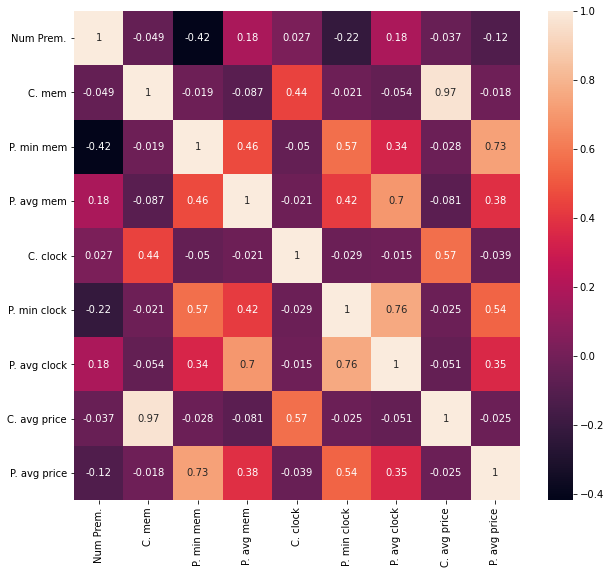

In [26]:
plt.figure(figsize=(10,9))
corr_df = ram_rules_feat
sn.heatmap(corr_df.corr(), annot=True)
plt.show()

No interesting correlations between the features of the consequents and their premises.  
The strongest, potentially interesting, correlation is the one between the number of premises and the min memory in the premises.

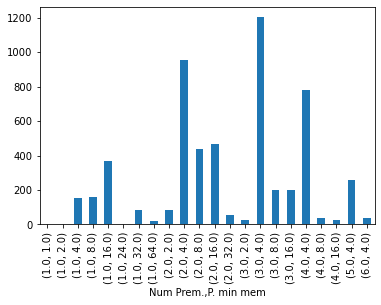

In [27]:
ram_rules_feat.groupby(["Num Prem.", "P. min mem"]).size().plot(kind="bar")
plt.show()

However there doesn't seem to be anything out of the ordinary.

#### Conclusions
There are no apparent relationships between the consequent and the premises of the ram modules sold.  

### Dataframe-level associations
Here we apply to the whole dataframe taking each row as its own transaction.

In [28]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

In [29]:
def filter_rules(rule_df, filter_func_list):
    
    for idx, row in rule_df.iterrows():
        
        prems = row.loc["Prem."]
        conseqs = row.loc["Conseq."]
        
        for filter_func in filter_func_list:
            if filter_func(prems, conseqs):
                
                rule_df = rule_df.drop(row.name)
                break #Already deleted, no need for further filtering
    
    return rule_df
                
                
def filter_country_continent_curr(prems, conseq):
    #Filters all associations between currency, country and continent
    
    curr_vals = df_geo["currency"].unique()
    country_vals = df_geo["country"].unique()
    contin_vals = df_geo["continent"].unique()
    
    for prem in prems:
        if prem in curr_vals:
            
            if conseq in country_vals or conseq in contin_vals:
                return True
            
        if prem in country_vals or prem in contin_vals:
            
            if conseq in curr_vals:
                return True
            
            if conseq in country_vals or conseq in contin_vals:
                return True
                    
    return False


def filter_brand_ram_name(prems, conseq):
    #Filter associations between brand and brand's product name
    
    brand_vals = df_ram["brand"].unique()
    name_vals = df_ram["name"].unique()
    
    for prem in prems:
        if prem in brand_vals and conseq in name_vals:
            return True
        if prem in name_vals and conseq in brand_vals:
            return True
        
    return False


#Filter if one of the elements in "prem_list" is contained in a rule's premises
def filter_by_premise_OR(rule_df, prem_list):
    
    for idx, row in rule_df.iterrows():
        for prem in row.loc["Prem."]:
            if prem in prem_list:
                rule_df = rule_df.drop(idx)
                
    return rule_df

#Filter if all of the elements in "prem_list" is contained in a rule's premises
def filter_by_premise_AND(rule_df, prem_list):
    
    for idx, row in rule_df.iterrows():
        
        match_count = 0
        for prem in row.loc["Prem."]:
            
            if prem in prem_list:
                match_count += 1
        
        if match_count == len(prem_list):
            rule_df = rule_df.drop(idx)
                
    return rule_df

#Filter if one of the elements in "conseq_list" is a rule's consequent
def filter_by_consequent_OR(rule_df, conseq_list):
    
    for idx, row in rule_df.iterrows():
        if row.loc["Conseq."] in conseq_list:
            rule_df = rule_df.drop(idx)
                
    return rule_df

A significant percentage of the rules discovered are "obvious" associations, such as "the transactions in country x use the currency of that country".  
In order to filter them out we created some ad-hoc filter rules.

In [30]:
filters = [filter_country_continent_curr, filter_brand_ram_name]

baskets_whole_df = df_sales_proc.drop(["time_code"], axis=1) #Remove time-related features
baskets_whole = baskets_whole_df.values.tolist()

#Apply apriori algorithm
rules_whole = fim_apriori(baskets_whole, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=100)

rules_whole_df = pd.DataFrame(rules_whole, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_whole_df.loc[:, "Prem. size"] = rules_whole_df.apply(lambda x: len(x["Prem."]), axis=1)

#Apply custom filters
rules_whole_df_filtered = filter_rules(rules_whole_df, filters)

print('Number of rules:', rules_whole_df_filtered.shape[0])

Number of rules: 1060


In order to focus the efforts on interesting associations, all the rules with a lift smaller than 1 are removed.

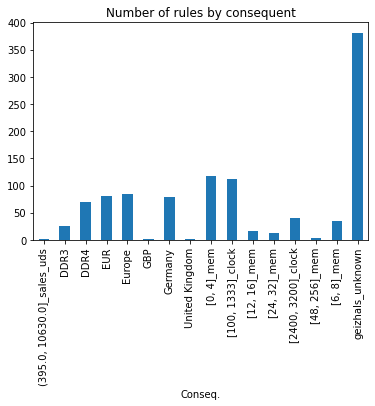

In [31]:
rules_whole_df_filtered.groupby("Conseq.").size().plot(kind="bar", title="Number of rules by consequent")
plt.show()

We will take a brief look at each consequent in order to see if there is any new information to be had.

#### Sales value

In [32]:
sales_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == '(395.0, 10630.0]_sales_uds']
sales_rules

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
43,"(395.0, 10630.0]_sales_uds","([48, 256]_mem, Europe)",168864,0.050517,0.893772,8.965215,2
44,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",194924,0.058313,0.883769,8.864869,1


Simpy show that the ram modules that have a lot of memory cost the most.

#### Memory type

In [33]:
memory_type_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(["DDR4", "DDR3"])]
memory_type_rules.sort_values(["Lift", "Prem. size"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
1,DDR4,"([3300, 4600]_clock,)",167989,0.050255,1.000000,2.836010,1
455,DDR4,"((395.0, 10630.0]_sales_uds, [2400, 3200]_clock)",154716,0.046285,0.897628,2.545681,2
1043,DDR4,"(United Kingdom, GBP, [2400, 3200]_clock, Europe)",154925,0.046347,0.893949,2.535249,4
1045,DDR4,"(United Kingdom, GBP, [2400, 3200]_clock)",154925,0.046347,0.893949,2.535249,3
1067,DDR4,"(United Kingdom, [2400, 3200]_clock, Europe)",154925,0.046347,0.893949,2.535249,3
...,...,...,...,...,...,...,...
1214,DDR3,"([1600, 1800]_clock, geizhals_unknown)",284374,0.085073,0.651421,1.520579,2
737,DDR3,"((57.0, 78.0]_sales_uds, [6, 8]_mem)",142086,0.042506,0.630955,1.472806,2
736,DDR3,"((57.0, 78.0]_sales_uds, [6, 8]_mem, Europe)",117148,0.035046,0.628402,1.466847,3
128,DDR3,"((78.0, 99.0]_sales_uds, [6, 8]_mem, Europe)",109521,0.032764,0.622438,1.452924,3


There are still plenty of rules containing redundant information (ie both Europe and UK in the same premise).  
In order to get a clear picture we need to remove them.

In [34]:
memory_type_rules_filter = filter_by_premise_AND(memory_type_rules, ["United Kingdom", "Europe"])
memory_type_rules_filter = filter_by_premise_AND(memory_type_rules_filter, ["United Kingdom", "GBP"])

memory_type_rules_filter.sort_values(["Lift", "Prem. size"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
1,DDR4,"([3300, 4600]_clock,)",167989,0.050255,1.000000,2.836010,1
455,DDR4,"((395.0, 10630.0]_sales_uds, [2400, 3200]_clock)",154716,0.046285,0.897628,2.545681,2
1075,DDR4,"(GBP, [2400, 3200]_clock, Europe)",154925,0.046347,0.893949,2.535249,3
1069,DDR4,"(United Kingdom, [2400, 3200]_clock)",154925,0.046347,0.893949,2.535249,2
1077,DDR4,"(GBP, [2400, 3200]_clock)",154925,0.046347,0.893949,2.535249,2
...,...,...,...,...,...,...,...
1214,DDR3,"([1600, 1800]_clock, geizhals_unknown)",284374,0.085073,0.651421,1.520579,2
737,DDR3,"((57.0, 78.0]_sales_uds, [6, 8]_mem)",142086,0.042506,0.630955,1.472806,2
736,DDR3,"((57.0, 78.0]_sales_uds, [6, 8]_mem, Europe)",117148,0.035046,0.628402,1.466847,3
128,DDR3,"((78.0, 99.0]_sales_uds, [6, 8]_mem, Europe)",109521,0.032764,0.622438,1.452924,3


Here the rules roughly point out which are the clock rates, price and memory size associated with DDR4.  
The only rule with confidence 1 shows that the highest clock range is reserved for DDR4 memory.

#### Currency

In [35]:
currency_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['EUR', 'GBP'])]
currency_rules.sort_values("Lift", ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
126,GBP,"(pricespy_unknown,)",289464,0.086596,0.908576,5.940088,1
1575,EUR,"([12, 16]_mem, DDR3, geizhals_unknown)",210049,0.062838,1.000000,1.424449,3
1483,EUR,"([6, 8]_mem, DDR3, geizhals_unknown)",262032,0.078389,1.000000,1.424449,3
1852,EUR,"([0, 4]_mem, DDR3, geizhals_unknown)",258722,0.077399,1.000000,1.424449,3
1407,EUR,"(G.SKILL, DDR3, geizhals_unknown)",249470,0.074631,1.000000,1.424449,3
...,...,...,...,...,...,...,...
1008,EUR,"(CRUCIAL,)",316985,0.094829,0.716784,1.021023,1
1364,EUR,"(G.SKILL, [2400, 3200]_clock)",183896,0.055014,0.714600,1.017912,2
1262,EUR,"([1600, 1800]_clock,)",490082,0.146613,0.711007,1.012793,1
1182,EUR,"([1600, 1800]_clock, [12, 16]_mem)",126685,0.037899,0.708347,1.009004,2


In [36]:
df_sales_merged.loc[df_sales_merged["name_vendor"] == "geizhals_unknown", "currency"].unique()

array(['EUR'], dtype=object)

As we pointed out in task 1, pricespy_unknown is a UK-based price search engine so no surprises here.  
Also, geizhals_unknown sells only in the EU so no need to keep the premises that contain it.

In [37]:
currency_rules_filter = filter_by_premise_OR(currency_rules, ["geizhals_unknown", "pricespy_unknown"])
currency_rules_filter.sort_values(["Prem. size", "Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
600,EUR,"((0.999, 27.0]_sales_uds, [100, 1333]_clock, [...",240907,0.072070,0.907675,1.292938,3
842,EUR,"(DDR2, [100, 1333]_clock, [0, 4]_mem)",272788,0.081607,0.869233,1.238179,3
300,EUR,"((27.0, 41.0]_sales_uds, [100, 1333]_clock, [0...",143360,0.042887,0.846606,1.205947,3
1707,EUR,"([100, 1333]_clock, [0, 4]_mem, DDR3)",159241,0.047638,0.808092,1.151086,3
651,EUR,"((0.999, 27.0]_sales_uds, [100, 1333]_clock)",241194,0.072155,0.906451,1.291194,2
1375,EUR,"(G.SKILL, [100, 1333]_clock)",168857,0.050515,0.880275,1.253907,2
1765,EUR,"([100, 1333]_clock, [0, 4]_mem)",561751,0.168053,0.876878,1.249069,2
699,EUR,"((0.999, 27.0]_sales_uds, [0, 4]_mem)",296180,0.088605,0.869767,1.238939,2
941,EUR,"(DDR2, [0, 4]_mem)",272788,0.081607,0.869233,1.238179,2
893,EUR,"(DDR2, [100, 1333]_clock)",305746,0.091467,0.866286,1.233980,2


From these rules we can extract some preferences of the european market for ram modules.  
The confidence 1 rules tell us that the german vendor Mindfactory sells only to EU customers and that the EU is the only market for DDR3L ram.

#### Country

In [38]:
country_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['Germany', 'United Kingdom'])]
country_rules.sort_values(["Prem. size", "Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
802,Germany,"(DDR2, [100, 1333]_clock, [0, 4]_mem, geizhals...",246588,0.073769,0.937273,1.450298,4
560,Germany,"((0.999, 27.0]_sales_uds, [100, 1333]_clock, [...",222440,0.066545,0.936862,1.449662,4
340,Germany,"((27.0, 41.0]_sales_uds, [0, 4]_mem, geizhals_...",196366,0.058745,0.937966,1.451371,3
1783,Germany,"([100, 1333]_clock, DDR3, geizhals_unknown)",269606,0.080655,0.937698,1.450956,3
1632,Germany,"([2400, 3200]_clock, DDR4, geizhals_unknown)",282483,0.084507,0.937582,1.450776,3
...,...,...,...,...,...,...,...
1451,Germany,"(G.SKILL,)",582554,0.174276,0.711674,1.101215,1
402,Germany,"((27.0, 41.0]_sales_uds,)",234892,0.070270,0.706068,1.092542,1
1005,Germany,"(CRUCIAL,)",293133,0.087693,0.662849,1.025666,1
1259,Germany,"([1600, 1800]_clock,)",452789,0.135456,0.656902,1.016464,1


In [39]:
df_sales_merged.loc[df_sales_merged["name_vendor"] == "geizhals_unknown", "country"].unique()

array(['Germany', 'Spain'], dtype=object)

We already know that whenever geizhals_unknown is involved the most likely country of sales is Germany, so we will ignore all rules containing it.  
Again, same idea applies to pricespy_unknown.

In [40]:
country_rules_filter = filter_by_premise_OR(country_rules, ["geizhals_unknown", "pricespy_unknown"])
country_rules_filter.sort_values(["Prem. size", "Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
593,Germany,"((0.999, 27.0]_sales_uds, [100, 1333]_clock, [...",225261,0.067389,0.848725,1.313283,3
835,Germany,"(DDR2, [100, 1333]_clock, [0, 4]_mem)",254014,0.075991,0.809410,1.252449,3
297,Germany,"((27.0, 41.0]_sales_uds, [100, 1333]_clock, [0...",133257,0.039865,0.786943,1.217684,3
1705,Germany,"([100, 1333]_clock, [0, 4]_mem, DDR3)",147747,0.044200,0.749764,1.160155,3
646,Germany,"((0.999, 27.0]_sales_uds, [100, 1333]_clock)",225530,0.067469,0.847583,1.311516,2
1372,Germany,"(G.SKILL, [100, 1333]_clock)",156989,0.046965,0.818406,1.266368,2
1758,Germany,"([100, 1333]_clock, [0, 4]_mem)",523363,0.156569,0.816956,1.264124,2
694,Germany,"((0.999, 27.0]_sales_uds, [0, 4]_mem)",276919,0.082843,0.813205,1.258321,2
936,Germany,"(DDR2, [0, 4]_mem)",254014,0.075991,0.809410,1.252449,2
888,Germany,"(DDR2, [100, 1333]_clock)",284882,0.085225,0.807171,1.248984,2


#### Memory size

In [41]:
memory_size_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem', '[48, 256]_mem'])]
memory_size_rules.sort_values(["Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
34,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, [2400, 3200]_clock)",105835,0.031662,0.614031,9.305955,2
36,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4, Europe)",123412,0.036920,0.610857,9.257848,3
38,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",145080,0.043402,0.607370,9.205001,2
504,"[24, 32]_mem","((246.0, 395.0]_sales_uds, geizhals_unknown, E...",116371,0.034813,0.661755,4.729775,4
505,"[24, 32]_mem","((246.0, 395.0]_sales_uds, geizhals_unknown, EUR)",116371,0.034813,0.661755,4.729775,3
...,...,...,...,...,...,...,...
190,"[0, 4]_mem","((41.0, 57.0]_sales_uds, Germany, EUR, Europe)",134230,0.040156,0.623766,2.139183,4
191,"[0, 4]_mem","((41.0, 57.0]_sales_uds, Germany, EUR)",134230,0.040156,0.623766,2.139183,3
193,"[0, 4]_mem","((41.0, 57.0]_sales_uds, Germany, Europe)",134230,0.040156,0.623766,2.139183,3
195,"[0, 4]_mem","((41.0, 57.0]_sales_uds, Germany)",134230,0.040156,0.623766,2.139183,2


In [42]:
memory_size_rules_filter = filter_by_premise_AND(memory_size_rules, ["Germany", "Europe"])
memory_size_rules_filter = filter_by_premise_AND(memory_size_rules_filter, ["Germany", "EUR"])

memory_size_rules_filter.sort_values(["Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
34,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, [2400, 3200]_clock)",105835,0.031662,0.614031,9.305955,2
36,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4, Europe)",123412,0.036920,0.610857,9.257848,3
38,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",145080,0.043402,0.607370,9.205001,2
504,"[24, 32]_mem","((246.0, 395.0]_sales_uds, geizhals_unknown, E...",116371,0.034813,0.661755,4.729775,4
505,"[24, 32]_mem","((246.0, 395.0]_sales_uds, geizhals_unknown, EUR)",116371,0.034813,0.661755,4.729775,3
...,...,...,...,...,...,...,...
197,"[0, 4]_mem","((41.0, 57.0]_sales_uds, EUR, Europe)",146236,0.043748,0.627278,2.151227,3
199,"[0, 4]_mem","((41.0, 57.0]_sales_uds, EUR)",146236,0.043748,0.627278,2.151227,2
1272,"[0, 4]_mem","(KINGSTON, [100, 1333]_clock)",134018,0.040093,0.624842,2.142874,2
195,"[0, 4]_mem","((41.0, 57.0]_sales_uds, Germany)",134230,0.040156,0.623766,2.139183,2


Here we can see the association rules between the memory size and the price/clock/memory type.  
These rules allow us (with varying confidence) to estimate the amount of memory in a module given some features of the sale.  

#### Clock

In [43]:
clock_rules = rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])]
clock_rules.sort_values(["Lift", "Confidence"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
897,"[100, 1333]_clock","(DDR2,)",352939,0.105585,1.000000,3.510793,1
896,"[100, 1333]_clock","(DDR2, Europe)",335706,0.100430,1.000000,3.510793,2
849,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",313826,0.093884,1.000000,3.510793,2
892,"[100, 1333]_clock","(DDR2, EUR, Europe)",305746,0.091467,1.000000,3.510793,3
894,"[100, 1333]_clock","(DDR2, EUR)",305746,0.091467,1.000000,3.510793,2
...,...,...,...,...,...,...,...
325,"[100, 1333]_clock","((27.0, 41.0]_sales_uds, EUR)",152102,0.045503,0.603094,2.117337,2
316,"[100, 1333]_clock","((27.0, 41.0]_sales_uds, Germany, EUR, Europe)",141440,0.042313,0.602149,2.114021,4
317,"[100, 1333]_clock","((27.0, 41.0]_sales_uds, Germany, EUR)",141440,0.042313,0.602149,2.114021,3
319,"[100, 1333]_clock","((27.0, 41.0]_sales_uds, Germany, Europe)",141440,0.042313,0.602149,2.114021,3


In [44]:
clock_rules_filter = filter_by_premise_AND(clock_rules, ["Germany", "Europe"])
clock_rules_filter = filter_by_premise_AND(clock_rules_filter, ["Germany", "EUR"])

clock_rules_filter.sort_values(["Lift", "Confidence"], ascending=False).head(20)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
897,"[100, 1333]_clock","(DDR2,)",352939,0.105585,1.0,3.510793,1
896,"[100, 1333]_clock","(DDR2, Europe)",335706,0.100430,1.0,3.510793,2
849,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",313826,0.093884,1.0,3.510793,2
892,"[100, 1333]_clock","(DDR2, EUR, Europe)",305746,0.091467,1.0,3.510793,3
894,"[100, 1333]_clock","(DDR2, EUR)",305746,0.091467,1.0,3.510793,2
847,"[100, 1333]_clock","(DDR2, [0, 4]_mem, Europe)",299174,0.089501,1.0,3.510793,3
869,"[100, 1333]_clock","(DDR2, geizhals_unknown, EUR, Europe)",295834,0.088502,1.0,3.510793,4
872,"[100, 1333]_clock","(DDR2, geizhals_unknown, EUR)",295834,0.088502,1.0,3.510793,3
875,"[100, 1333]_clock","(DDR2, geizhals_unknown, Europe)",295834,0.088502,1.0,3.510793,3
877,"[100, 1333]_clock","(DDR2, geizhals_unknown)",295834,0.088502,1.0,3.510793,2


These are the associations between the clock and the other features.  
We can see that, as we pointed out in the pre-processing step, the lowest clock range is very strongly associated with low-end ram (low memory/cost/DDR2).  
However all the rules containing DDR2 in the premise seem to lead to the same consequent, so we need to filter them.

In [45]:
clock_rules_filter_2 = filter_by_premise_OR(clock_rules_filter, ["DDR2"])
clock_rules_filter_2.sort_values(["Lift", "Confidence"], ascending=False).head(50)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Prem. size
563,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem, geizhals...",222440,0.066545,0.815758,2.863957,4
568,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem, geizhals...",237431,0.071030,0.815712,2.863797,5
572,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem, geizhals...",237431,0.071030,0.815712,2.863797,4
576,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem, geizhals...",237431,0.071030,0.815712,2.863797,4
579,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem, geizhals...",237431,0.071030,0.815712,2.863797,3
623,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, geizhals_unknown, Ge...",222706,0.066625,0.815429,2.862804,3
627,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, geizhals_unknown, EU...",237715,0.071115,0.815383,2.862640,4
630,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, geizhals_unknown, EUR)",237715,0.071115,0.815383,2.862640,3
633,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, geizhals_unknown, Eu...",237715,0.071115,0.815383,2.862640,3
635,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, geizhals_unknown)",237715,0.071115,0.815383,2.862640,2


There are also strong rules connecting DDR4 memory with [2400, 3200]_clock, however they do not has as high of a confidence score due to sharing that range with DDR3.

### Comparison between top countries
In this section we will take a look at a few top countries ordered by the volume of sales and compare the frequent sequences found, in order to see if there are any apparent differences.

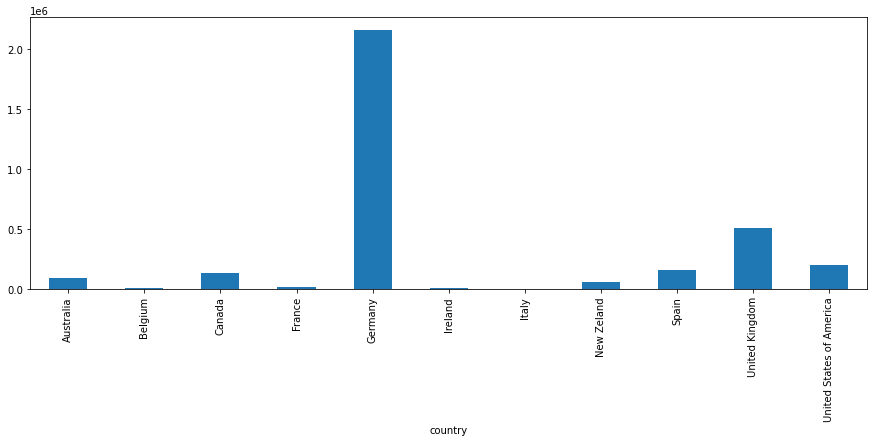

In [46]:
plt.figure(figsize=(15,5))
df_sales_proc.groupby("country").size().plot(kind="bar")
plt.show()

We will consider Germany, the UK and the US.

In [47]:
ram_sales_ger = df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]
ram_sales_uk = df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]
ram_sales_us = df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]

We will also filter out rules that contain either redundant information or that rely on premises that are not shareable between different countries (ie vendors, since all of the big ones are not really international).

#### Rules Germany

In [48]:
#Remove country/time-related features
baskets_ger_df = df_sales_proc.loc[df_sales_proc["country"] == "Germany"].drop(["time_code", "country", "region", "name_vendor"], axis=1)
baskets_ger_df = baskets_ger_df.values.tolist()

#Keep only entries with Lift >= 1
rules_ger = fim_apriori(baskets_ger_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=100)

rules_ger_df = pd.DataFrame(rules_ger, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_ger_df.loc[:, "Country"] = "Germany"

print('Number of rules:', rules_ger_df.shape[0])

Number of rules: 572


In [49]:
rules_ger_df_filtered = filter_rules(rules_ger_df, filters)
rules_ger_df_filtered = filter_by_premise_OR(rules_ger_df_filtered, ["Europe"])
rules_ger_df_filtered = filter_by_premise_OR(rules_ger_df_filtered, ["EUR"])

rules_ger_df_filtered = filter_by_consequent_OR(rules_ger_df_filtered, ["Europe"])
rules_ger_df_filtered = filter_by_consequent_OR(rules_ger_df_filtered, ["EUR"])

print('Number of rules (filtered):', rules_ger_df_filtered.shape[0])

Number of rules (filtered): 48


#### Rules UK

In [50]:
#Remove country/time-related features
baskets_uk_df = df_sales_proc.loc[df_sales_proc["country"] == "United Kingdom"]\
    .drop(["time_code", "country", "region", "name_vendor"], axis=1)
baskets_uk_df = baskets_uk_df.values.tolist()

#Keep only entries with Lift >= 1
rules_uk = fim_apriori(baskets_uk_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=100)

rules_uk_df = pd.DataFrame(rules_uk, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_uk_df.loc[:, "Country"] = "United Kingdom"

print('Number of rules:', rules_uk_df.shape[0])

Number of rules: 896


In [51]:
rules_uk_df_filtered = filter_rules(rules_uk_df, filters)
rules_uk_df_filtered = filter_by_premise_OR(rules_uk_df_filtered, ["Europe"])
rules_uk_df_filtered = filter_by_premise_OR(rules_uk_df_filtered, ["GBP"])

rules_uk_df_filtered = filter_by_consequent_OR(rules_uk_df_filtered, ["Europe"])
rules_uk_df_filtered = filter_by_consequent_OR(rules_uk_df_filtered, ["GBP"])

print('Number of rules (filtered):', rules_uk_df_filtered.shape[0])

Number of rules (filtered): 83


#### Rules US

In [52]:
#Remove country/time-related features
baskets_us_df = df_sales_proc.loc[df_sales_proc["country"] == "United States of America"]\
        .drop(["time_code", "country", "region", "name_vendor"], axis=1)
baskets_us_df = baskets_us_df.values.tolist()

#Keep only entries with Lift >= 1
rules_us = fim_apriori(baskets_us_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=100)

rules_us_df = pd.DataFrame(rules_us, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_us_df.loc[:, "Country"] = "United States of America"

print('Number of rules:', rules_us_df.shape[0])

Number of rules: 848


In [53]:
rules_us_df_filtered = filter_rules(rules_us_df, filters)
rules_us_df_filtered = filter_by_premise_OR(rules_us_df_filtered, ["America"])
rules_us_df_filtered = filter_by_premise_OR(rules_us_df_filtered, ["USD"])

rules_us_df_filtered = filter_by_consequent_OR(rules_us_df_filtered, ["America"])
rules_us_df_filtered = filter_by_consequent_OR(rules_us_df_filtered, ["USD"])

print('Number of rules (filtered):', rules_us_df_filtered.shape[0])

Number of rules (filtered): 83


#### Comparison
We will take a look at the most interesting rules (starting with those with the highest lift score) and try to understand if/why there are differences between the countries.

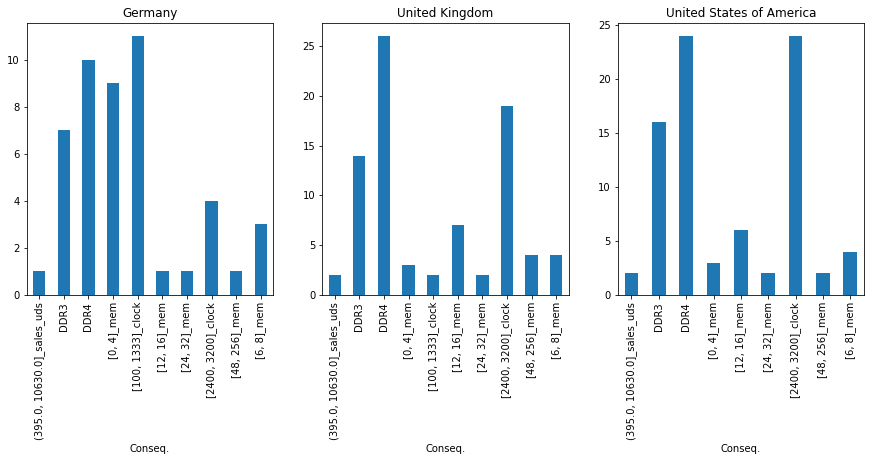

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
rules_ger_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[0], title="Germany")
rules_uk_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[1], title="United Kingdom")
rules_us_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

In [55]:
rules_joint_df = rules_ger_df_filtered.append(rules_uk_df_filtered, ignore_index=True).append(rules_us_df_filtered, ignore_index=True)
rules_joint_df.head()

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
0,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",84270,0.039009,0.622364,9.972547,Germany
1,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",119799,0.055456,0.888605,9.360514,Germany
2,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",130956,0.060620,0.649828,4.991779,Germany
3,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",148577,0.068777,0.715513,3.131516,Germany
4,DDR4,"([24, 32]_mem, [2400, 3200]_clock)",92009,0.042592,0.842203,2.949384,Germany


##### Sales price

In [56]:
rules_joint_df.loc[rules_joint_df["Conseq."] == '(395.0, 10630.0]_sales_uds']

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
1,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",119799,0.055456,0.888605,9.360514,Germany
50,"(395.0, 10630.0]_sales_uds","([48, 256]_mem, DDR4)",30980,0.060592,0.943362,7.621546,United Kingdom
52,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",38567,0.075431,0.906030,7.319942,United Kingdom
132,"(395.0, 10630.0]_sales_uds","([48, 256]_mem, DDR4)",8695,0.043602,0.810798,11.053250,United States of America
133,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",9753,0.048908,0.787231,10.731964,United States of America


Germany shows the usual high memory -> high cost rule for this consequent.

The UK is more interesting, showing that the majority of the sales in this bracket are DDR4 (about 30K entries) while also having a sizable amount of ram with memory type DDR3 or older in the same range (about 8K entries).

The US behaves similarly to the UK in terms of distribution of memory type for the highest price range.

##### DDR3

In [57]:
rules_joint_df.loc[(rules_joint_df["Conseq."] == 'DDR3')]

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
41,DDR3,"([1600, 1800]_clock, [6, 8]_mem)",98392,0.045546,0.696068,1.664756,Germany
42,DDR3,"([1600, 1800]_clock,)",310196,0.143592,0.685078,1.638473,Germany
43,DDR3,"([1600, 1800]_clock, [0, 4]_mem)",87365,0.040442,0.684824,1.637864,Germany
44,DDR3,"([1600, 1800]_clock, [12, 16]_mem)",79540,0.036820,0.679759,1.625752,Germany
45,DDR3,"([6, 8]_mem, [100, 1333]_clock)",76574,0.035447,0.619225,1.480975,Germany
46,DDR3,"((78.0, 99.0]_sales_uds, [6, 8]_mem)",79824,0.036951,0.618484,1.479202,Germany
47,DDR3,"((57.0, 78.0]_sales_uds, [6, 8]_mem)",85178,0.039430,0.613052,1.466210,Germany
74,DDR3,"([1600, 1800]_clock, [6, 8]_mem)",33937,0.066376,1.000000,2.149895,United Kingdom
75,DDR3,"([1600, 1800]_clock, KINGSTON)",31001,0.060633,1.000000,2.149895,United Kingdom
76,DDR3,"([1600, 1800]_clock, [0, 4]_mem)",28236,0.055225,1.000000,2.149895,United Kingdom


The UK and US share the rule associating the [1600, 1800]_clock range to DDR3 almost completely (confidence almost 1), while the situation in Germany is more nuanced (0.68 confidence).  

They also share a strong association between [100, 1333]_clock and DDR3, while again in Germany there are no simple associations.  

Finally, there are also interesting rules connecting modules' brands to DDR3, such as Kingston and Mushkin, while Germany doesn't show any strong brand-related association.

Brand


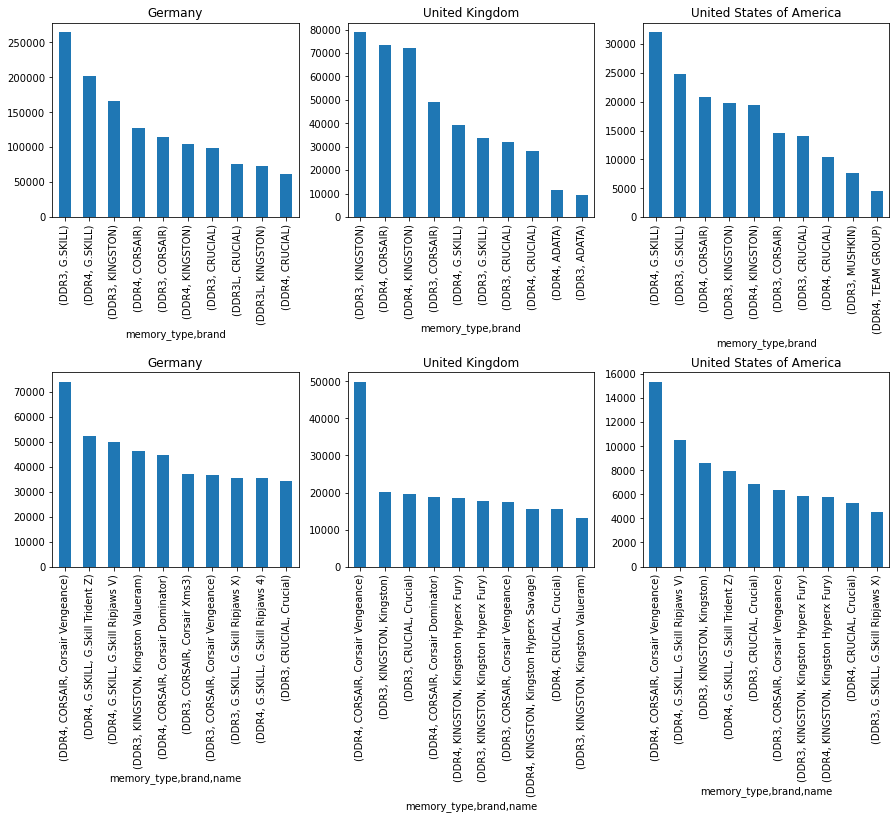

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [58]:
print("Brand")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.8, wspace=0.2)

df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][2], title="United States of America")

df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][2], title="United States of America")

plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

The lack of brand/name premises in Germany is due to the low support, while for premises containing just brands it's due to the more evenly distributed sales of both DDR3 and DDR4 by the same vendors (lowering the rule confidence below the 60% threshold).

##### DDR4

In [59]:
rules_joint_df.loc[rules_joint_df["Conseq."] == 'DDR4']

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
4,DDR4,"([24, 32]_mem, [2400, 3200]_clock)",92009,0.042592,0.842203,2.949384,Germany
13,DDR4,"([2400, 3200]_clock,)",381118,0.176422,0.788188,2.760223,Germany
17,DDR4,"([2400, 3200]_clock, [12, 16]_mem)",119542,0.055337,0.759315,2.659111,Germany
22,DDR4,"([48, 256]_mem, (395.0, 10630.0]_sales_uds)",84270,0.039009,0.703428,2.463396,Germany
23,DDR4,"([2400, 3200]_clock, G.SKILL)",114655,0.053075,0.691559,2.421831,Germany
24,DDR4,"([48, 256]_mem,)",92808,0.042961,0.688400,2.410767,Germany
27,DDR4,"((395.0, 10630.0]_sales_uds,)",135403,0.062679,0.660258,2.312214,Germany
28,DDR4,"([2400, 3200]_clock, [6, 8]_mem)",80526,0.037276,0.660239,2.312147,Germany
29,DDR4,"(Corsair Vengeance, CORSAIR)",74178,0.034338,0.630867,2.209289,Germany
30,DDR4,"(Corsair Vengeance,)",74178,0.034338,0.630867,2.209289,Germany


All countries present associations between Corsair Vengeance modules and DDR4, with UK/US having rules with a confidence of 1 while Germany has some weaker rules.  
The same holds for the premises [2400, 3200]_clock and ([2400, 3200]_clock, G.SKILL).  

The association between [48, 256]_mem and DDR4 holds across all countries.

Clock


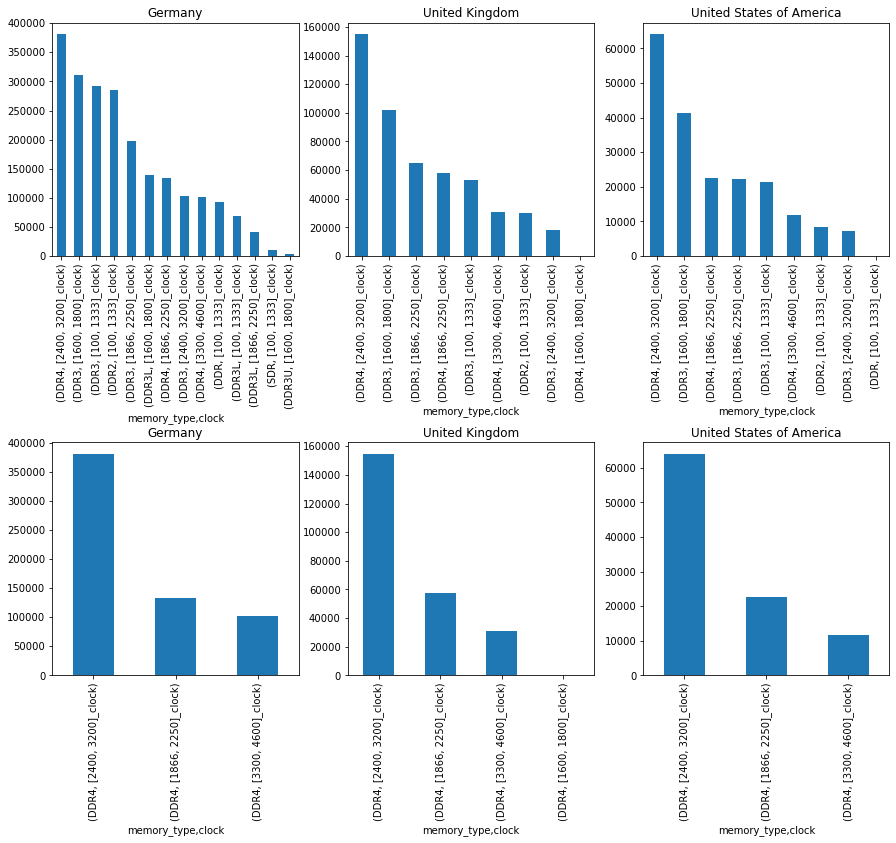

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [60]:
print("Clock")

fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.8, wspace=0.2)

df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[0][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[0][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[0][2], title="United States of America")

df_sales_proc.loc[(df_sales_proc["country"] == "Germany") & (df_sales_proc["memory_type"] == "DDR4")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[1][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom") & (df_sales_proc["memory_type"] == "DDR4")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[1][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America") & (df_sales_proc["memory_type"] == "DDR4")]\
        .groupby(["memory_type", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[1][2], title="United States of America")

plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Countrary to the UK/US, Germany lacks a clock-related rule including [3300, 4600]_clock.  
This seems due to a low support.

In [61]:
df_sales_proc.loc[(df_sales_proc["country"] == "Germany") & \
                  (df_sales_proc["clock"] == "[3300, 4600]_clock") & \
                  (df_sales_proc["memory_type"] == "DDR4")].shape[0]

102195

##### Memory size

In [62]:
rules_joint_df.loc[rules_joint_df["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem', '[48, 256]_mem'])]

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
0,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",84270,0.039009,0.622364,9.972547,Germany
2,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",130956,0.060620,0.649828,4.991779,Germany
3,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",148577,0.068777,0.715513,3.131516,Germany
5,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",225261,0.104275,0.998807,2.943585,Germany
6,"[0, 4]_mem","((0.999, 27.0]_sales_uds,)",276919,0.128188,0.998392,2.942362,Germany
7,"[6, 8]_mem","((78.0, 99.0]_sales_uds, DDR3)",79824,0.036951,0.704425,2.939902,Germany
12,"[0, 4]_mem","((27.0, 41.0]_sales_uds, [100, 1333]_clock)",133257,0.061686,0.942145,2.776596,Germany
16,"[6, 8]_mem","((57.0, 78.0]_sales_uds,)",138941,0.064317,0.638067,2.662960,Germany
18,"[0, 4]_mem","(DDR2, [100, 1333]_clock)",254014,0.117585,0.891646,2.627771,Germany
19,"[0, 4]_mem","(DDR2,)",254014,0.117585,0.891646,2.627771,Germany


All the rules here roughly describe the relationship between a module's price/memory type/clock and it's memory size.  
In general they seem to confirm that the higher the memory size the higher the price/module's features.  

Some of the rules shown before also reappear here inverted (ie. DDR2 -> [0,4]_mem).  

Following are some explanations for differences in the rules between countries.

Clock


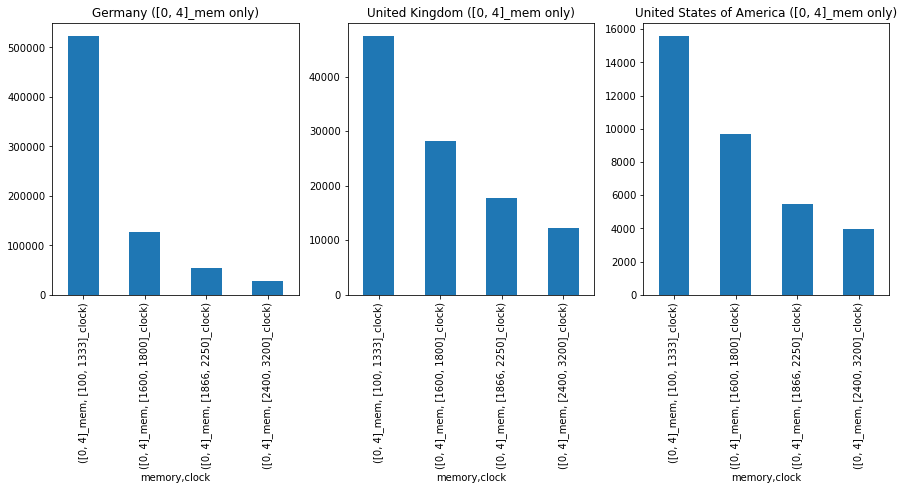

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [63]:
print("Clock")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany ([0, 4]_mem only)")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom ([0, 4]_mem only)")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America ([0, 4]_mem only)")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

In Germany there is an association rule with [100, 1333]_clock as a premise and [0, 4]_mem as a consequent.  
We can see that this is due to a low confidence score in the UK/US, in which the distribution of these features in the ram sales is less concentrated.

Memory type


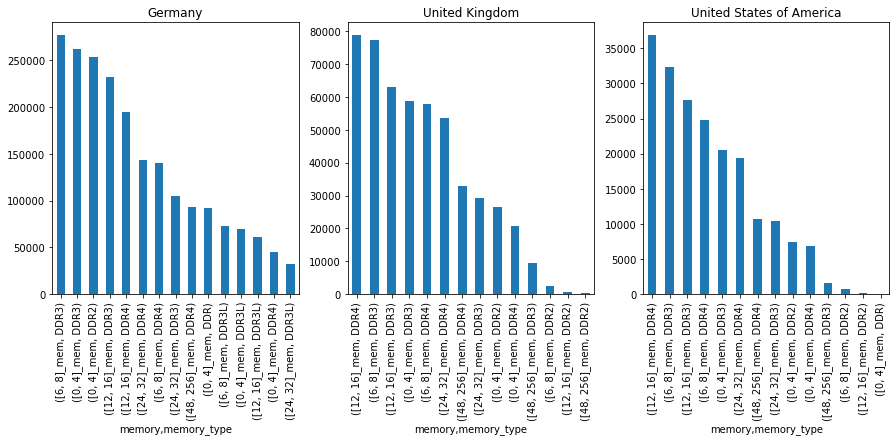

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [66]:
print("Memory type")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Germany and the UK present an association between DDR2 and [0, 4]_mem.  
This rule is absent in the US due to a low support.  
It seems that no other rule of this kind exists (having a memory type as its only premise) due to the more varied distribution of capacities for DDR3/DDR4 type of ram, resulting in a low confidence score.

Sales (USD)


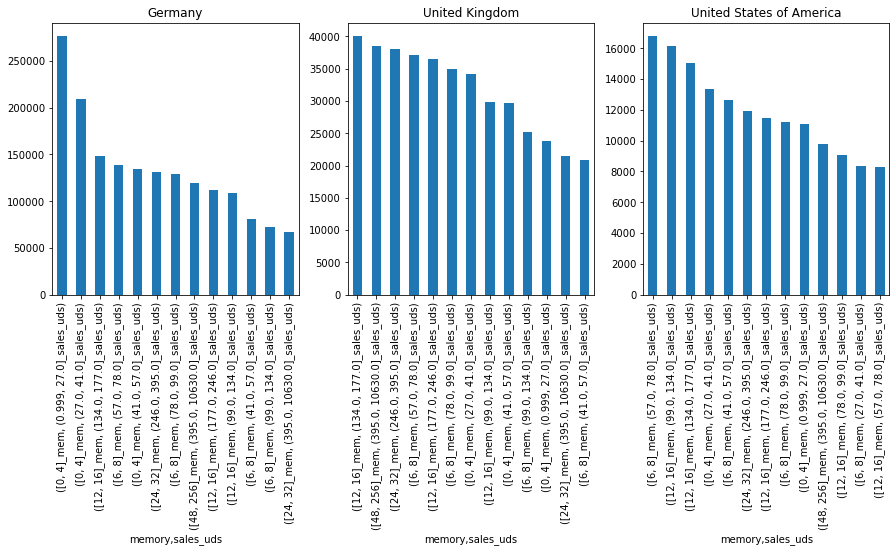

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [67]:
print("Sales (USD)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Both Germany and the US present an association between (0.999, 27.0]_sales_uds and [0,4]_mem.  
The UK's lack is due to the low support of the rule.

##### Clock

In [68]:
rules_joint_df.loc[rules_joint_df["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])]

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
8,"[100, 1333]_clock","(DDR2,)",284882,0.131874,1.000000,2.884212,Germany
9,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",254014,0.117585,1.000000,2.884212,Germany
10,"[2400, 3200]_clock","([24, 32]_mem, DDR4)",92009,0.042592,0.640865,2.863142,Germany
11,"[2400, 3200]_clock","((395.0, 10630.0]_sales_uds, DDR4)",85995,0.039808,0.635104,2.837404,Germany
14,"[2400, 3200]_clock","(DDR4,)",381118,0.176422,0.617828,2.760223,Germany
15,"[2400, 3200]_clock","([12, 16]_mem, DDR4)",119542,0.055337,0.613225,2.739655,Germany
25,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem)",225261,0.104275,0.813454,2.346175,Germany
26,"[100, 1333]_clock","((0.999, 27.0]_sales_uds,)",225530,0.104399,0.813116,2.345199,Germany
31,"[100, 1333]_clock","(G.SKILL, [0, 4]_mem)",87216,0.040373,0.734741,2.119149,Germany
32,"[100, 1333]_clock","([0, 4]_mem,)",523363,0.242269,0.713990,2.059297,Germany


Brand


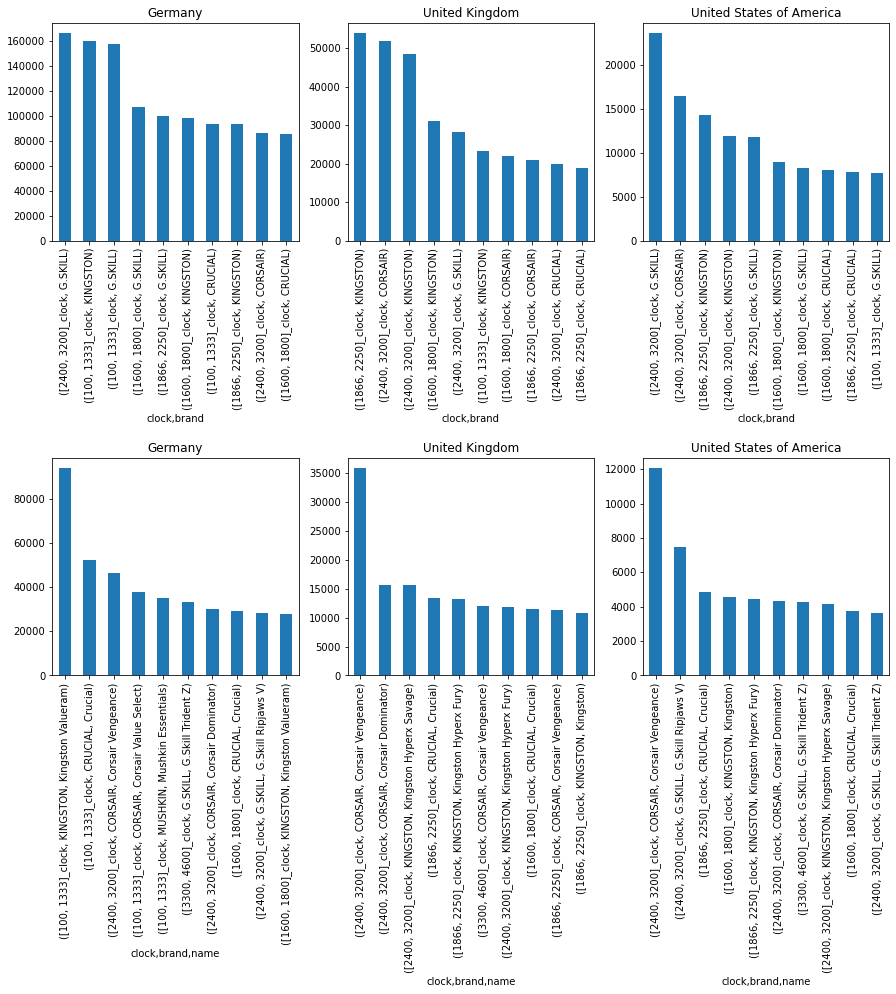

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [69]:
print("Brand")

fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.subplots_adjust(hspace=1.0, wspace=0.2)

df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "brand"]).size().nlargest(10).plot(kind="bar", ax=axes[0][2], title="United States of America")

df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "brand", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1][2], title="United States of America")

plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Again we find that in the UK/US the Corsair/Gskill DDR4 modules are associated with the high-end of products, while in Germany specific brands are only associated to the low-end of clock speeds.  
Again this is due to the different distribution of sold ram's brands/names.

Memory type


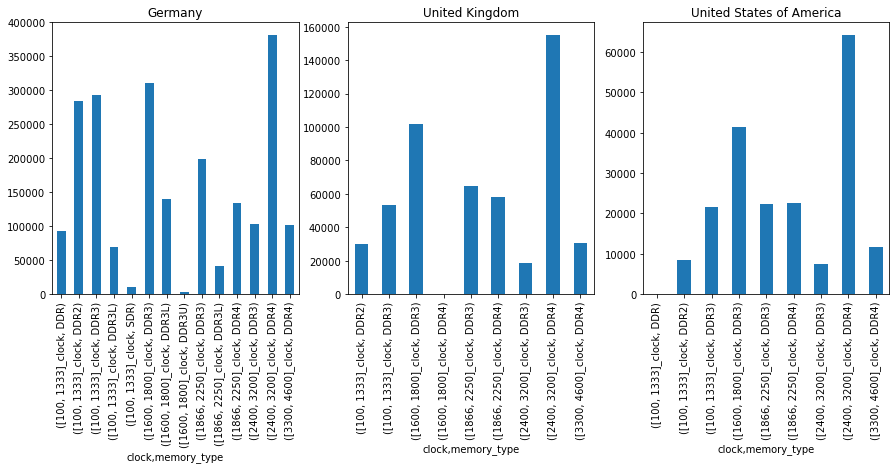

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [70]:
print("Memory type")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Both Germany and the UK have a rule associating DDR2 with [100, 1333]_clock	(in accordance with the rules above), the US lacks such a rule due to a low support for DDR2.  

Memory size


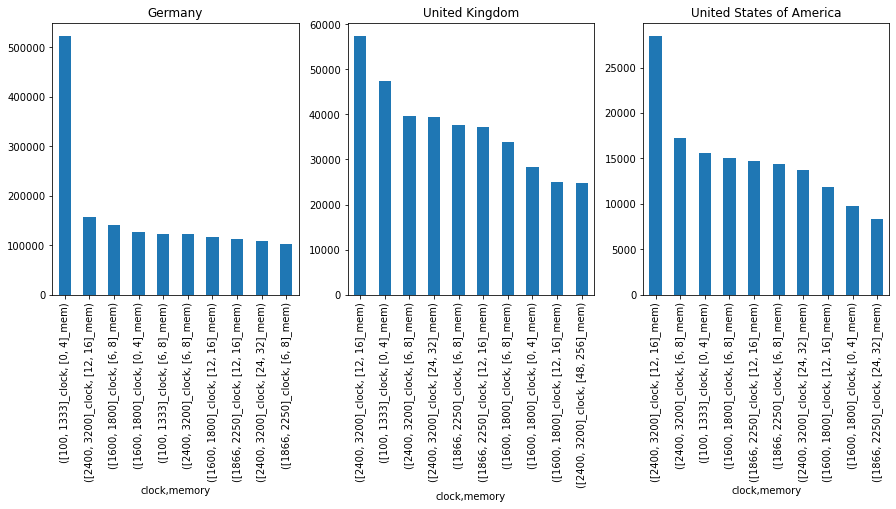

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [71]:
print("Memory size")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Germany is the only country with a rule with memory size as a premise ([0, 4]_mem).  
This rule is not true for the UK/US due to a low confidence score.

Sales (USD)


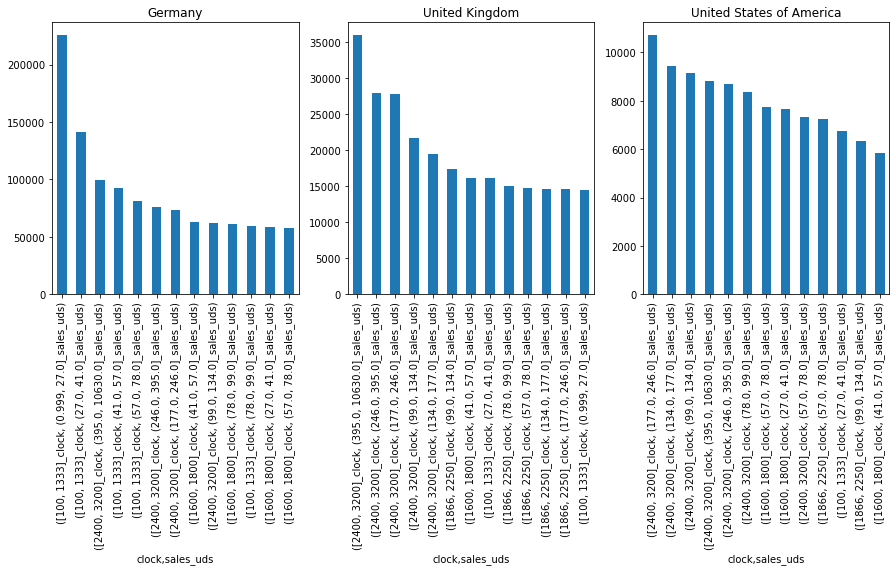

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [72]:
print("Sales (USD)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger.shape[0]}, 5% support: {ram_sales_ger.shape[0]*5//100}')
print(f'Total ram sales UK {ram_sales_uk.shape[0]}, 5% support: {ram_sales_uk.shape[0]*5//100}')
print(f'Total ram sales US {ram_sales_us.shape[0]}, 5% support: {ram_sales_us.shape[0]*5//100}')

Germany presents an association rule between [100, 1333]_clock and (0.999, 27.0]_sales_uds, respectively the lowest clock range and price range.  
This rule is not present in the UK/US due to the low confidence score.

### Conclusions
These are some of the interesting differences found between the top selling countries.  
Plenty of rules, regarding price in particular, are left unexplored due to the sheer amount of them that we found and because we think that a "data understanding"-style of analysis is more fitting for this type research.

## Frequent ram sequences
Here we will try to find interesting information regarding the ram sales mining frequent sequences from a database built using time/location features and containing the ram_codes as singleton elements.  

In order to make the task computationally/time efficient we will sample the sales dataset in order to ensure a quick execution of the apriori algorithm.

### Time-based ram baskets  
In this section we simply grouped the sales by time, generating sequences with elements of size 1, where each element represents a ram module sale in that timeframe.

#### Week

In [73]:
baskets_sampled_week = df_sales_proc.sample(frac=0.002, random_state=0)
print(f"Entries sampled: {baskets_sampled_week.shape[0]}")

Entries sampled: 6685


In [74]:
baskets_week = baskets_sampled_week.groupby(pd.Grouper(key="time_code", freq="1W"))["ram_code"].apply(lambda x: [[y] for y in x])
baskets_week

time_code
2013-03-24                                             [[2432]]
2013-03-31     [[1568], [1683], [2618], [2982], [2434], [2483]]
2013-04-07     [[2778], [1644], [1470], [1486], [2772], [2131]]
2013-04-14    [[780], [2383], [1678], [2809], [1050], [1491]...
2013-04-21    [[1056], [425], [1936], [1537], [2773], [1464]...
                                    ...                        
2018-03-18    [[975], [1598], [861], [649], [711], [866], [3...
2018-03-25    [[2446], [117], [595], [2793], [1965], [1585],...
2018-04-01    [[694], [843], [3581], [1569], [162], [2724], ...
2018-04-08    [[2033], [237], [3407], [2045], [1904], [2221]...
2018-04-15    [[1041], [2445], [2443], [2276], [1169], [1362...
Freq: W-SUN, Name: ram_code, Length: 265, dtype: object

In [75]:
format_baskets = []
for row in baskets_week.values:
    format_baskets.append(row)
    
support = np.ceil(baskets_week.shape[0]*5/100)
print(f"Min. Support (abs): {support}")
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Min. Support (abs): 14.0


For computational reasons we limited the search for support >= 5%.

In [76]:
result_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_week_df["Supp. (frac)"] = result_week_df["Supp. (abs)"]/baskets_week.shape[0]
result_week_df["Seq. len"] = result_week_df["Seq."].apply(lambda x: len(x))

In [77]:
result_week_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False)

,Seq.,Supp. (abs),Supp. (frac),Seq. len
0,[[2185]],20,0.075472,1
9,[[656]],19,0.071698,1
13,[[804]],18,0.067925,1
15,[[977]],18,0.067925,1
2,[[2188]],17,0.064151,1
3,[[2189]],17,0.064151,1
8,[[655]],17,0.064151,1
1,[[2186]],16,0.060377,1
6,[[2440]],16,0.060377,1
11,[[659]],16,0.060377,1


##### Sub-sequences of length 1

We found found mostly sub-sequences of length one, meaning that the support is measuring which ram module have been sold consistently and for a long enough time (in this case the support asks for at least 14 weeks).

In [78]:
list_idx = []

for idx, row in result_week_df.iterrows():
    list_idx.append((row["Seq."][0][0]))
    

df_sales_proc.loc[df_sales_proc["ram_code"].isin(list_idx)].groupby("ram_code").size().describe()

count      16.000000
mean     6751.062500
std      1523.647486
min      3666.000000
25%      5530.750000
50%      7329.500000
75%      7971.250000
max      8664.000000
dtype: float64

In [79]:
df_sales_proc.groupby("ram_code").size().describe()

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
dtype: float64

Note that the volume of sales for the ram module with the least support is greater than the 75% quantile value of all the other modules that don't reach the support threshold.

#### Month

In [80]:
baskets_sampled_month = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_month.shape[0]}")

Entries sampled: 2674


For computational reasons, we reduce the amount datapoints sampled.

In [81]:
baskets_month = baskets_sampled_month.groupby(pd.Grouper(key="time_code", freq="1M"))["ram_code"].apply(lambda x: [[y] for y in x])
baskets_month

time_code
2013-03-31                     [[1683], [2618], [2982], [2434]]
2013-04-30    [[2778], [2131], [780], [2383], [1678], [2809]...
2013-05-31    [[1498], [2381], [2149], [2427], [774], [2436]...
2013-06-30    [[939], [1446], [552], [1043], [1248], [1456],...
2013-07-31    [[1487], [1248], [1084], [1303], [766], [636],...
                                    ...                        
2017-12-31    [[822], [2129], [2067], [2077], [2046], [1378]...
2018-01-31    [[864], [593], [1628], [522], [2131], [955], [...
2018-02-28    [[857], [3], [764], [2298], [1907], [1339], [2...
2018-03-31    [[1640], [2978], [973], [2299], [2322], [2213]...
2018-04-30    [[618], [2033], [237], [2527], [1244], [3468],...
Freq: M, Name: ram_code, Length: 62, dtype: object

In [82]:
format_baskets = []
for row in baskets_month.values:
    format_baskets.append(row)

support = np.ceil(baskets_month.shape[0]*5/100)
print(f"Min. Support (abs): {support}")
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Min. Support (abs): 4.0


In [83]:
result_month_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_month_df["Supp. (frac)"] = result_month_df["Supp. (abs)"]/baskets_month.shape[0]
result_month_df["Seq. len"] = result_month_df["Seq."].apply(lambda x: len(x))

In [84]:
result_month_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head()

,Seq.,Supp. (abs),Supp. (frac),Seq. len
157,"[[1392], [1397]]",4,0.064516,2
158,"[[2188], [2440]]",4,0.064516,2
159,"[[2188], [977]]",4,0.064516,2
160,"[[656], [804]]",4,0.064516,2
161,"[[860], [147]]",4,0.064516,2


This time we have sub-sequences of length 2, even though they have a low support.

#### Analysis

In [85]:
an_ram = df_ram.loc[[1392, 1397, 2188, 2440, 2188, 977, 656, 804, 860, 147]]
an_ram = an_ram.reset_index("ram_code").astype({"ram_code":str}).set_index("ram_code") #Change indexes to string
an_ram

,brand,name,memory,memory_type,clock
ram_code,,,,,
1392,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,2800
1397,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,3466
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400
656,CORSAIR,Corsair Vengeance,16.0,DDR4,2400
804,CRUCIAL,Crucial,8.0,DDR3,1600
860,CRUCIAL,Crucial,16.0,DDR4,2133


Taking a look at the features of these rams we notice that they are mostly in the memory range [8, 16] while the other features differ.  
This coupled to the fact that these ram sizes are the most popular seem to hint to the associations being just about ram modules popular/convenient enough to be sold each month.

In [86]:
an_ram["Vol."] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code").size()
an_ram["Tot. sales usd"] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code")["sales_uds"].sum()
an_ram

,brand,name,memory,memory_type,clock,Vol.,Tot. sales usd
ram_code,,,,,,,
1392,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,2800,3267,4.814733e+05
1397,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,3466,2148,4.293315e+05
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600,6734,8.961790e+05
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133,5596,2.622301e+05
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600,6734,8.961790e+05
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400,5335,8.181866e+05
656,CORSAIR,Corsair Vengeance,16.0,DDR4,2400,7975,1.396966e+06
804,CRUCIAL,Crucial,8.0,DDR3,1600,7915,7.044548e+05
860,CRUCIAL,Crucial,16.0,DDR4,2133,6996,1.182165e+06


In [87]:
display(df_sales_merged.groupby("ram_code").size().describe().rename("Vol. sales"))
display(df_sales_merged.groupby("ram_code")["sales_uds"].sum().describe().rename("Tot. sales usd"))

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
Name: Vol. sales, dtype: float64

count    3.111000e+03
mean     1.893328e+05
std      3.349330e+05
min      2.025000e+01
25%      9.536781e+03
50%      5.839220e+04
75%      2.077376e+05
max      4.310282e+06
Name: Tot. sales usd, dtype: float64

Again we can see that both the sales volume and the sales total of the ram modules found are close to the maximum of the entire dataset.

#### Year
The computation of this grouping is problematic given that it contains very few sequences (which makes the support have the same absolute value for different percentages ie 5% == 1 abs, 10% == 1 abs, 20% == 1 abs).  

It also seems less useful to find sequences of ram_codes through the years given that there is a constant release of new ram modules in the market with different features/id.

### Location-based ram baskets
Similarly to the time-based section above, here we use different geographical features to define the sequences.

#### Region

In [88]:
baskets_sampled_region = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_region.shape[0]}")

Entries sampled: 2674


In [89]:
baskets_region = baskets_sampled_region.groupby(["region"])["ram_code"].apply(lambda x: [[y] for y in x])
baskets_region.head()

region
analucia              [[2517], [961], [2531], [1588], [1303], [678],...
aragon                                           [[1425], [657], [642]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1383], [2308], [2038], [2217], [1580], [2046...
bavaria               [[1419], [1836], [1365], [2183], [1649], [1177...
Name: ram_code, dtype: object

In [90]:
format_baskets = []
for row in baskets_region.values:
    format_baskets.append(row)
    
support = np.ceil(baskets_region.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [91]:
result_region_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_df["Supp. (frac)"] = result_region_df["Supp. (abs)"]/baskets_region.shape[0]
result_region_df["Seq. len"] = result_region_df["Seq."].apply(lambda x: len(x))

result_region_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head(10)

,Seq.,Supp. (abs),Supp. (frac),Seq. len
8,[[656]],13,0.185714,1
3,[[2185]],11,0.157143,1
10,[[804]],10,0.142857,1
1,[[147]],9,0.128571,1
5,[[2440]],9,0.128571,1
0,[[1392]],8,0.114286,1
4,[[2188]],8,0.114286,1
9,[[659]],8,0.114286,1
13,[[977]],8,0.114286,1
2,[[1591]],7,0.100000,1


Here we have sub-sequences of length 2 again.

#### Analysis

In [92]:
an_ram = df_ram.loc[[2440, 977, 515, 1581, 589, 1248]]
an_ram = an_ram.reset_index("ram_code").astype({"ram_code":str}).set_index("ram_code") #Change indexes to string
an_ram["Vol."] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code").size()
an_ram

,brand,name,memory,memory_type,clock,Vol.
ram_code,,,,,,
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133,5596
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400,5335
515,CORSAIR,Corsair Dominator,16.0,DDR4,3600,2222
1581,G.SKILL,G.Skill Trident Z,8.0,DDR4,3733,1411
589,CORSAIR,Corsair Value Select,8.0,DDR3L,1333,1643
1248,G.SKILL,G.Skill Nt,4.0,DDR2,800,2108


In [93]:
display(df_sales_merged.groupby("ram_code").size().describe().rename("Vol. sales"))

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
Name: Vol. sales, dtype: float64

We can already see that the sales for these modules are not that high compared to the previous case of a sequence of length 2.  
The interesting thing is that these sequences, compared to the ones above, are shared across multiple regions.  

Of course these are not the only ram sequences shared across regions.  
These results are heavily influenced by the sampling process, however we do not see any other way to perform this kind of analysis without additional computational resources.

#### Country/Continent grouping
We skipped this grouping due to the time required to execute the apriori algorithm on any significant enough sample size.

### Location/time-based ram baskets
Sequences defined by location while elements are defined by unit of time.

#### Region/week

In [94]:
baskets_sampled_region_week = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_region_week.shape[0]}")

Entries sampled: 3343


In [95]:
baskets_region_week = baskets_sampled_region_week.groupby(["region", pd.Grouper(key="time_code", freq="1W")])["ram_code"]\
        .apply(lambda x: list(x))
baskets_region_week = baskets_region_week.groupby("region").apply(lambda x: [y for y in x])

baskets_region_week.head()

region
analucia              [[2982], [1936], [1936], [2381], [2455, 769], ...
aragon                                           [[1425], [642], [657]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1414], [2046], [979], [657], [2211], [2328],...
bavaria               [[2779], [2796], [1646], [2390], [733], [1430]...
Name: ram_code, dtype: object

In [96]:
format_baskets = []
for row in baskets_region_week.values:
    format_baskets.append(row)

support = np.ceil(baskets_region_week.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Support threshold is 10% for computational reasons.

In [97]:
result_region_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_week_df["Supp. (frac)"] = result_region_week_df["Supp. (abs)"]/baskets_region_week.shape[0]
result_region_week_df["Seq. len"] = result_region_week_df["Seq."].apply(lambda x: len(x))
result_region_week_df["Max elem. len"] = result_region_week_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [98]:
display(result_region_week_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head())
display(result_region_week_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head())

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


Only length 1 singleton sequences.

#### Region/month

In [99]:
baskets_sampled_region_month = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_region_month.shape[0]}")

Entries sampled: 3343


In [100]:
baskets_region_month = baskets_sampled_region_month.groupby(["region", pd.Grouper(key="time_code", freq="1M")])["ram_code"]\
        .apply(lambda x: list(x))
baskets_region_month = baskets_region_month.groupby("region").apply(lambda x: [y for y in x])

baskets_region_month.head()

region
analucia              [[2982], [1936, 1936], [2381], [2455, 769], [1...
aragon                                           [[1425], [642], [657]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1414], [2046, 979], [657], [2328, 2211], [23...
bavaria               [[2779], [2796, 1646], [2390, 733], [1430], [1...
Name: ram_code, dtype: object

In [101]:
format_baskets = []
for row in baskets_region_month.values:
    format_baskets.append(row)

support = np.ceil(baskets_region_month.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [102]:
result_region_month_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_month_df["Supp. (frac)"] = result_region_month_df["Supp. (abs)"]/baskets_region_month.shape[0]
result_region_month_df["Seq. len"] = result_region_month_df["Seq."].apply(lambda x: len(x))
result_region_month_df["Max elem. len"] = result_region_month_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [103]:
display(result_region_month_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head())
display(result_region_month_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head())

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


Only length 1 singleton sequences.

#### (Country, continent)/(week, month)
The computational time is too high for any significantly big sample size.

### Conclusions frequent ram sequences
Again, using only the ram_codes as the events in our sequence's elements wasn't really fruitful.  
We only managed to find out a subset (due to sampling) of the most popular ram modules sold across time/geography.

## Frequent sales sequences
In the next few sections we define the sequences by grouping the sales by a unit of time/space and use the sales entries as elements of the sequences with their relative features as events.

In [104]:
target_feat = ["brand", "name", "memory", "memory_type", "clock", "sales_uds"]
df_sales_proc.loc[:, target_feat]

,brand,name,memory,memory_type,clock,sales_uds
2602347,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602348,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602349,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602350,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602351,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
...,...,...,...,...,...,...
6014673,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014674,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014675,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014676,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"


Here we define which features we are interested in for the next few sections.  
We ignore features that are already accounted for in the sequences (ie time/location) or that we are not interested in (ie ram_code, vendor).

### Time-based sales sequences

#### Week

In [105]:
baskets_sampled_week = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_week.shape[0]}")

Entries sampled: 3343


In [106]:
baskets_week = baskets_sampled_week.groupby(["name_vendor", pd.Grouper(key="time_code", freq="1W")])[target_feat]\
        .apply(lambda x: list(x.values))
baskets_week = baskets_week.groupby("name_vendor").apply(lambda x: [y for y in x][0])

baskets_week.head()

name_vendor
1stWave Technologies    [[CORSAIR, Corsair Vengeance, [12, 16]_mem, DD...
ARLT                    [[KINGSTON, Kingston, [0, 4]_mem, DDR3, [100, ...
Adorama                 [[CRUCIAL, Crucial Ballistix Tactical, [12, 16...
Alternate               [[G.SKILL, G.Skill Sniper, [6, 8]_mem, DDR3, [...
Alternate Italia        [[KINGSTON, Kingston, [6, 8]_mem, DDR3, [100, ...
dtype: object

In [107]:
format_baskets = []
for row in baskets_week.values:
    format_baskets.append(row)

support = np.ceil(baskets_week.shape[0]*5/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [108]:
result_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_week_df["Supp. (frac)"] = result_week_df["Supp. (abs)"]/baskets_week.shape[0]
result_week_df["Seq. len"] = result_week_df["Seq."].apply(lambda x: len(x))
result_week_df["Max elem. len"] = result_week_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [109]:
display(result_week_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head(10))

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
115,"[[DDR3, KINGSTON]]",16,0.266667,1,2
126,"[[DDR3, [6, 8]_mem]]",16,0.266667,1,2
134,"[[DDR4, [2400, 3200]_clock]]",16,0.266667,1,2
88,"[[CORSAIR, DDR4]]",13,0.216667,1,2
122,"[[DDR3, [1600, 1800]_clock]]",13,0.216667,1,2
86,"[[CORSAIR, Corsair Vengeance]]",12,0.200000,1,2
123,"[[DDR3, [1866, 2250]_clock]]",12,0.200000,1,2
121,"[[DDR3, [12, 16]_mem]]",11,0.183333,1,2
132,"[[DDR4, [1866, 2250]_clock]]",11,0.183333,1,2
150,"[[KINGSTON, [1866, 2250]_clock]]",11,0.183333,1,2


With the benefit of knowledge from task 1 the information gathered here is not surprising.  
The associations seem clear enough in their motivation, there doesn't seem to be a reason for further analysis.

### Location-based sales sequences

#### Region

In [110]:
baskets_sampled_region = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_region.shape[0]}")

Entries sampled: 2674


In [111]:
baskets_region = baskets_sampled_region.groupby(["name_vendor", "region"])[target_feat]\
        .apply(lambda x: list(x.values))
baskets_region = baskets_region.groupby("name_vendor").apply(lambda x: [y for y in x][0])

baskets_region.head()

name_vendor
1stWave Technologies    [[CORSAIR, Corsair Vengeance, [12, 16]_mem, DD...
ARLT                    [[KINGSTON, Kingston, [0, 4]_mem, DDR3, [100, ...
Adorama                 [[CRUCIAL, Crucial, [0, 4]_mem, DDR2, [100, 13...
Alternate               [[G.SKILL, G.Skill Sniper, [6, 8]_mem, DDR3, [...
Alternate Italia        [[KINGSTON, Kingston, [6, 8]_mem, DDR3, [100, ...
dtype: object

In [112]:
format_baskets = []
for row in baskets_region.values:
    format_baskets.append(row)

support = np.ceil(baskets_region.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Minimum support at 10%.

In [113]:
result_region_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_region_df["Supp. (frac)"] = result_region_df["Supp. (abs)"]/baskets_region.shape[0]
result_region_df["Seq. len"] = result_region_df["Seq."].apply(lambda x: len(x))
result_region_df["Max elem. len"] = result_region_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [114]:
display(result_region_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head(20))

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
122,"[[DDR4, [2400, 3200]_clock]]",29,0.491525,1,2
119,"[[DDR4, [12, 16]_mem]]",23,0.389831,1,2
110,"[[DDR3, [1600, 1800]_clock]]",21,0.355932,1,2
120,"[[DDR4, [1866, 2250]_clock]]",21,0.355932,1,2
113,"[[DDR3, [6, 8]_mem]]",20,0.338983,1,2
82,"[[CORSAIR, DDR4]]",18,0.305085,1,2
116,"[[DDR4, KINGSTON]]",18,0.305085,1,2
105,"[[DDR3, KINGSTON]]",17,0.288136,1,2
141,"[[KINGSTON, [1866, 2250]_clock]]",16,0.271186,1,2
153,"[[[12, 16]_mem, [2400, 3200]_clock]]",16,0.271186,1,2


Again, these associations don't offer much of a reason for further analysis since they match what we would expect from the domain that we are working in.

### Conclusions
Even with this approach we didn't find any new intriguing piece of information, unfortunately.  
It was mostly a re-run of the whole-dataframe association rules analysis from above, which makes given that we are once again working with the ram features directly.

## Frequent sequences conclusions
We are inclined to think that the reason behind the lack of new results is that the dataset, by design, contains transactions that have no connection to one another.  
Since ram is a product that is bought only once in a while by most customers there is no point in keeping track of multiple sales to the same buyer (which would make for an obvious way to define the elements of the sequences, similar to what happens in a supermarket).  

The only connections found inter-element are those regarding their joint popularity in sales during a particular period of time/location, but there doesn't seem to be anything more to it.

Intra-element, instead, we just rediscovered part of the information from task 1 and associations rule sections.

In general the computational complexity of the task didn't help us in finding meaningful associations, we might have missed something due to sampling but all in all the analysis of frequent sequences doesn't seem to be the right tool for this dataset.